# Micro-project: LMA descriptors
Juan Alonso - SMC08 - jalons19@student.aau.dk

##### Please, be sure to have the package ipywidgets installed
using pip:

`pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension`

using conda: 

`conda install ipywidgets`

### Jump to
- [Raw data](#data) 2D plots of the MoCap data
- [Kinematic descriptors](#kinematic) Functions for calculating velocity, acceleration, jerk and magnitude
- [Effort descriptors](#effort) Functions for calculating weight, time, space and flow
- [Playground](#playground) Selection of joints + kinematic descriptors using a GUI. Display of effort descriptors.

##### To do
- Make the kinematic descriptors interactive, leting the user choose the weights and number of frames.
- Computed velocity and acceleration have different scaling than the provided.
- Computed velocity and acceleration seem to be noisier than the provided.

#### Imports

In [18]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import time as timer

import ipywidgets as widgets

%config InlineBackend.figure_format = 'retina'

#### Convenience functions

In [17]:
#Padding wrapper
def zp(A, p, rightPad = True):
    if rightPad:
        return np.pad(A, ((0,p), (0,0)), 'constant')
    else:
        return np.pad(A, ((p, 0), (0,0)), 'constant')

#### GUI

In [4]:
plot_output = widgets.Output()
plot_output.layout.height = '550px'

joint_dropdown = widgets.Dropdown(
    options=['Head', 'Right hand', 'Left hand'],
    value='Head',
    description='Joint:',
)

descriptor_dropdown = widgets.Dropdown(
    options=['Velocity', 'Acceleration', 'Jerk'],
    value='Velocity',
    description='Descriptor:',
)

go_button = widgets.Button(
    description='Calculate descriptors',
    disabled=False,
    button_style='primary', 
    tooltip='Click me',
    icon='calculator',
    layout=widgets.Layout(width='auto')
)

def go_eventhandler(change):
    kinematic_calculation(joint_dropdown.value, descriptor_dropdown.value)    

go_button.on_click(go_eventhandler)
    
def kinematic_calculation(joint, descriptor):
    
    pairs = [('X','seagreen'),('Y','slateblue'),('Z','indianred')]
      
    joint = joint_dropdown.index * 3;
    capture_data = []
    
    if descriptor_dropdown.index == 0:
        k = velocity(mc_data[:,joint:joint+3], dt=0.015)
        capture_data = vel_data[:,joint:joint+3]
    elif descriptor_dropdown.index == 1:
        k = acceleration(mc_data[:,joint:joint+3], dt=0.03)
        capture_data = acc_data[:,joint:joint+3]
    else:
        k = jerk(mc_data[:,joint:joint+3])
        
    mag_k = magnitude(k)

    plot_output.clear_output()     
    with plot_output:

        fig, axs = plt.subplots(4, 1, figsize=(14,8), sharey=True)
        fig.suptitle('{} values for {}'.format(descriptor_dropdown.value, joint_dropdown.value.lower()), fontsize=16)
        fig.subplots_adjust(top=0.935)
        
        for coordinate in range(0,3):
            axs[coordinate].plot(k[:,coordinate], color=pairs[coordinate][1], linewidth=2.0, alpha=0.65, label='estimated')
            if descriptor_dropdown.index <=1:
                axs[coordinate].plot(capture_data[:,coordinate], color='black', linewidth=1.0, label='from file')
            axs[coordinate].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False)
            axs[coordinate].text(0.01, 0.08,pairs[coordinate][0], transform=axs[coordinate].transAxes, fontsize=12)
            legend = axs[coordinate].legend(loc='lower right')
            
        axs[3].plot(mag_k, color='gray')
        axs[3].text(0.01, 0.08,'Magnitude', transform=axs[3].transAxes, fontsize=12)
        
        plt.xlabel('samples')       
        plt.show()

#### Read MoCap data

In [5]:
mc_data = genfromtxt('SmoothedPos.tsv', skip_header=10)
vel_data = genfromtxt('Velocity.tsv', skip_header=10)
acc_data = genfromtxt('Acceleration.tsv', skip_header=10)

## Raw data<a id='data'></a>

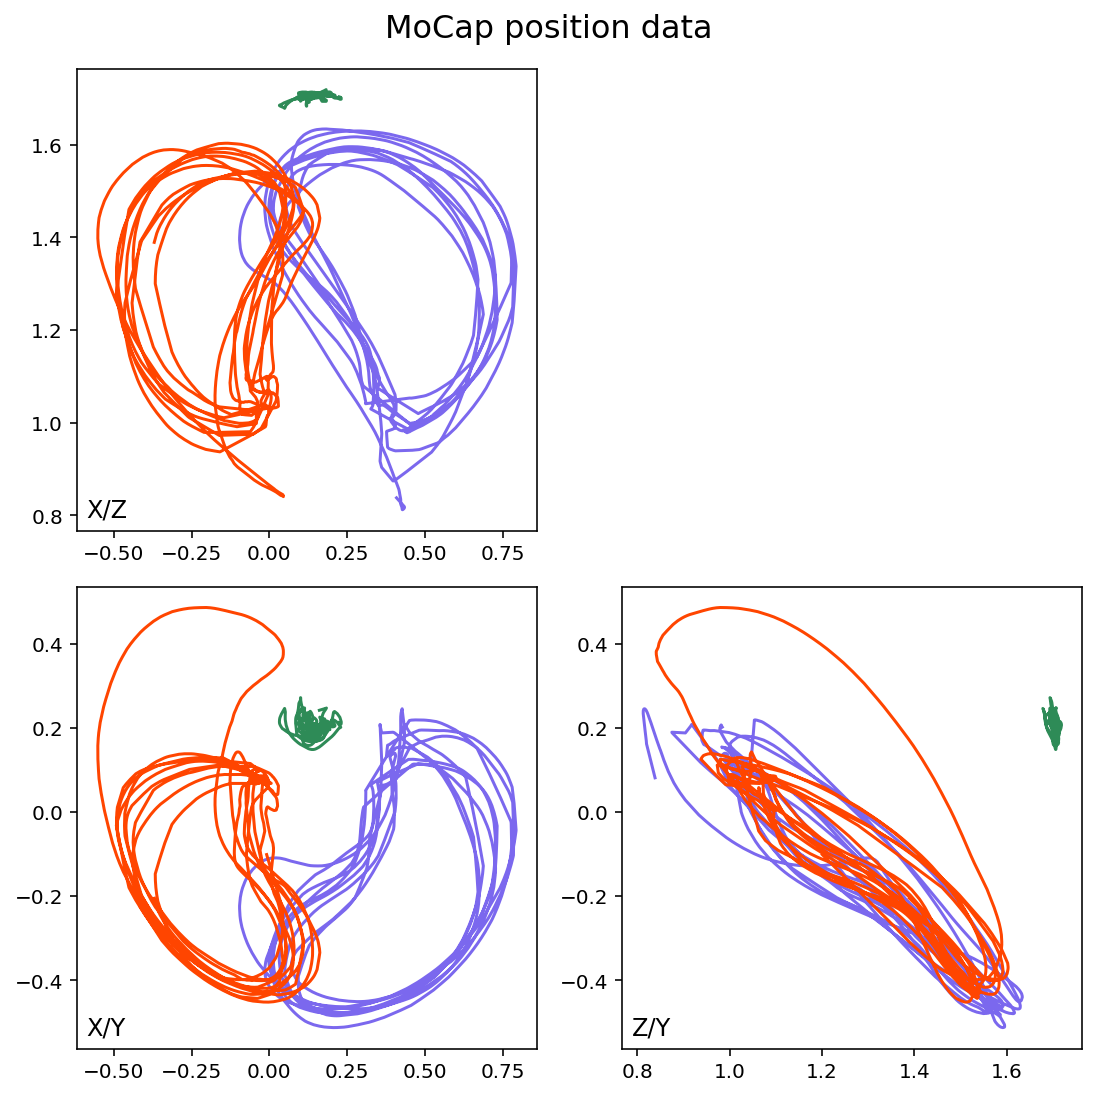

In [6]:
x,y,z = (0,1,2)
pairs = [(x,z,'X/Z'),(x,y,'X/Y'),(z,y,'Z/Y')]

fig, axs = plt.subplots(2, 2, figsize=(7.5, 7.5), constrained_layout=True)

for index, subplot in enumerate([0,2,3]):

    c1, c2, legend = pairs[index]
    pc1 = subplot // 2
    pc2 = subplot % 2
    
    axs[pc1][pc2].plot(mc_data[:,c1], mc_data[:,c2], color='seagreen')
    axs[pc1][pc2].plot(mc_data[:,3+c1], mc_data[:,3+c2], color='mediumslateblue')
    axs[pc1][pc2].plot(mc_data[:,6+c1], mc_data[:,6+c2], color='orangered')
    axs[pc1][pc2].text(0.02, 0.03,legend, transform=axs[pc1][pc2].transAxes, fontsize=12)
    
plt.subplot(2, 2, 2)
plt.axis('off')

fig.suptitle('MoCap position data', fontsize=16)

plt.show()

## Kinematic descriptors <a id='kinematic'></a>

In [7]:
def velocity(A, dt=0.01):
    v = (zp(A[2:,],2)-A)/(2*dt)
    return v[:-2]

def acceleration(A, dt=0.01):
    a = (zp(A[2:,],2)-2*zp(A[1:,],1)+A)/(dt**2)
    return a[:-2]

def jerk(A, dt=0.01):
    j = (zp(A[4:,],4)-2*zp(A[3:,],3)+2*zp(A[1:,],1)-A)/(2*dt**3)
    return j[:-4]

def magnitude(A, squared=False):
    mag = A[:,0]**2 + A[:,1]**2 + A[:,2]**2
    return mag if squared else np.sqrt(mag)

## Effort descriptors<a id='effort'></a>

In [8]:
def weight(A, dt=0.01, T=1, weights=(1.0,1.0,1.0)):
    
    mv_j0 = magnitude(velocity(A[:,0:3], dt), squared=True)
    mv_j1 = magnitude(velocity(A[:,3:6], dt), squared=True)
    mv_j2 = magnitude(velocity(A[:,6:9], dt), squared=True)
    weight = weights[0] * mv_j0 + weights[1] * mv_j1 + weights[2] * mv_j2 

    offset = 0
    w = []
    o = []
    while offset + T <= weight.shape[0]:   
        w.append(np.amax(weight[offset:offset+T]))
        offset = offset + T
        o.append(offset)

    return w,o

In [9]:
def time(A, dt=0.01, T=1, weights=(1.0,1.0,1.0)):
    
    aj0 = magnitude(acceleration(A[:,0:3], dt))
    aj1 = magnitude(acceleration(A[:,3:6], dt))
    aj2 = magnitude(acceleration(A[:,6:9], dt))
    time = weights[0] * aj0 + weights[1] * aj1 + weights[2] * aj2 
    
    offset = 0
    t = []
    o = []
    while offset + T <= time.shape[0]:
        t.append(np.sum(time[offset:offset+T])/T)
        offset = offset + T 
        o.append(offset)
        
    return t,o

In [10]:
def space(A, dt=0.01, T=2, weights=(1.0,1.0,1.0)):
    
    offset = 0
    s = []
    o = []
    epsilon = np.finfo(float).eps
    while offset + T <= A.shape[0]:
        space = 0
        for joint in range(0,3):
            
            numerator = 0
            for ti in range(1,T):
                numerator = numerator + magnitude(np.reshape(A[offset+ti,joint*3:joint*3+3] - A[offset+ti-1,joint*3:joint*3+3],(1,3)))[0]  
            denominator = magnitude(np.reshape(A[offset+T-1,joint*3:joint*3+3] - A[offset,joint*3:joint*3+3],(1,3)))[0]
            space_joint = numerator/(denominator+epsilon)
            space_joint = space_joint * weights[joint]
            space = space + space_joint
            
        s.append(space)
        offset = offset + T
        o.append(offset)

    return s,o

In [11]:
def flow(A, dt=0.01, T=1, weights=(1.0,1.0,1.0)):

    jj0 = magnitude(jerk(A[:,0:3], dt))
    jj1 = magnitude(jerk(A[:,3:6], dt))
    jj2 = magnitude(jerk(A[:,6:9], dt))
    weighted_jerk = weights[0] * jj0 + weights[1] * jj1 + weights[2] * jj2
    
    offset = 0
    f = []
    o = []
    while offset + T <= weighted_jerk.shape[0]:
        f.append(np.sum(weighted_jerk[offset:offset+T])/T)
        offset = offset + T
        o.append(offset)

    return f,o

## Playground<a id='playground'></a>
### Kinematic descriptors

In [23]:
widgets.VBox([
    widgets.HBox([
        joint_dropdown, 
        descriptor_dropdown, 
        go_button]), 
    plot_output])

### Effort descriptors

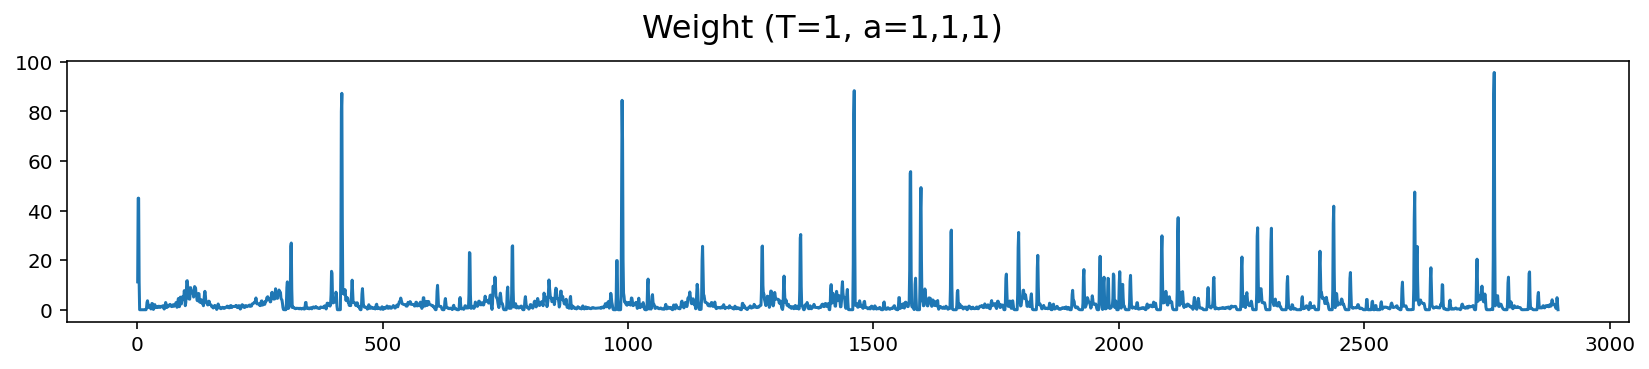

In [19]:
T = 1
weights=(1,1,1)
w,o = weight(mc_data, T=T, weights=weights)

fig = plt.figure(figsize=(14, 2.5),)
fig.suptitle('Weight (T={}, a={},{},{})'.format(T, weights[0], weights[1], weights[2]), fontsize=16)
plt.subplots_adjust(top=0.85)
plt.plot(o,w)
plt.show()

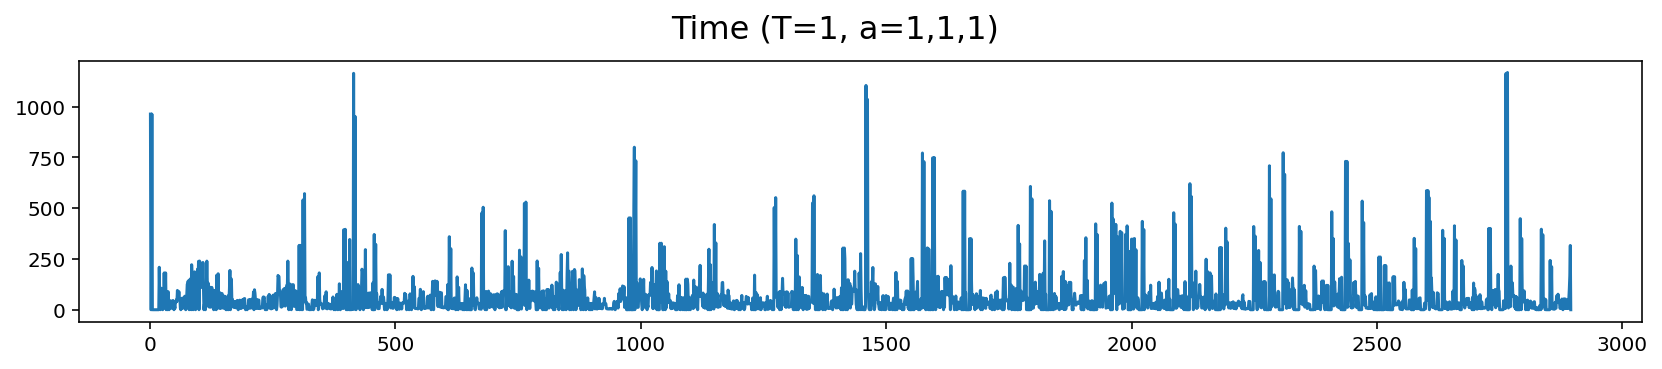

In [20]:
T = 1
weights=(1,1,1)
t,o = time(mc_data, T=T, weights=weights)

fig = plt.figure(figsize=(14, 2.5))
fig.suptitle('Time (T={}, a={},{},{})'.format(T, weights[0], weights[1], weights[2]), fontsize=16)
plt.subplots_adjust(top=0.85)
plt.plot(o,t)
plt.show()

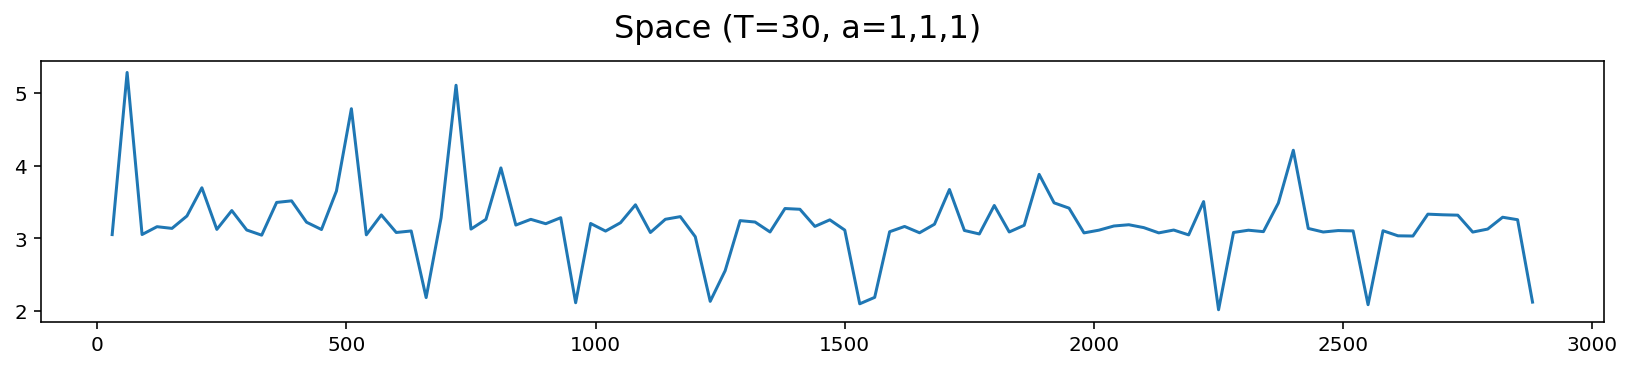

In [21]:
T = 30
weights=(1,1,1)
s,o = space(mc_data, T=T, weights=weights)

fig = plt.figure(figsize=(14, 2.5))
fig.suptitle('Space (T={}, a={},{},{})'.format(T, weights[0], weights[1], weights[2]), fontsize=16)
plt.subplots_adjust(top=0.85)
plt.plot(o,s)
plt.show()

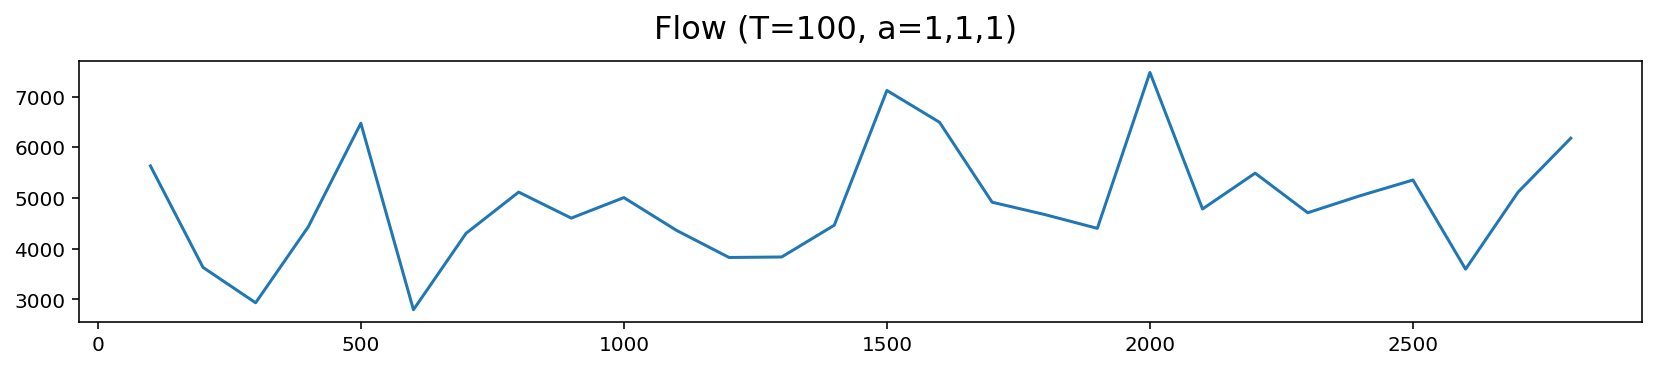

In [22]:
T = 100
weights=(1,1,1)
f,o = flow(mc_data, T=T, weights=weights)

fig = plt.figure(figsize=(14, 2.5))
fig.suptitle('Flow (T={}, a={},{},{})'.format(T, weights[0], weights[1], weights[2]), fontsize=16)
plt.subplots_adjust(top=0.85)
plt.plot(o,f)
plt.show()